# **Exemplos de aplicações da grade BR-DWGD com auxílio da linguagem Python**

**Scripts baseados nas apresentações para o Programa de Pós-Graduação em Ciências Climáticas (PPGMet) da Universidade Federal do Rio Grande do Norte e do Programa de Pós-Graduação em Meteorologia Universidade Federal de Santa Maria, em 2022 e 2023, respectivamente**

Autor: Alexandre Cândido Xavier, do Dep. de Engenharia Rural da UFES, campus de Alegre.


* **Trabalhos dos dados**

  * Xavier, A. C., Scanlon, B. R., King, C. W., & Alves, A. I. (2022). New improved Brazilian    daily weather gridded data (1961–2020). International Journal of Climatology, 42(16), 8390– 8404. https://doi.org/10.1002/joc.7731

  * Xavier, A.C., King, C.W. and Scanlon, B.R. (2016), Daily gridded meteorological variables in Brazil (1980–2013). *International Journal of Climatology*, 36: 2644-2659. https://doi.org/10.1002/joc.4518

* **Baixar esta apresentação, sistema Ubuntu** 

$wget https://github.com/AlexandreCandidoXavier/BR-DWGD/blob/main/exemplos/apresentacao_UFRN_UFSM.ipynb

* **Informações da grade [aqui](https://sites.google.com/site/alexandrecandidoxavierufes/brazilian-daily-weather-gridded-data?authuser=0)**

* **Para download dos arquivos NetCDF [aqui](https://drive.google.com/drive/u/1/folders/11-qnvwojirAtaQxSE03N0_SUrbcsz44N)   ou [aqui](https://ufesbr-my.sharepoint.com/personal/alexandre_xavier_ufes_br/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Falexandre%5Fxavier%5Fufes%5Fbr%2FDocuments%2Fnetcdf%5Ffiles&ga=1)**

* **Códigos em arquivos ".py" e mais exemplo [aqui](https://github.com/AlexandreCandidoXavier/BR-DWGD)**


# **Informações Gerais do ambiente de apresentação**

* Estes códigos estão sendo rodados em Python 3.10 no ambiente [JupyterLab](https://jupyter.org/)
* Abaixo estão as principais bibliotecas.
  * **[Numpy](https://numpy.org/)**
  * **[Xarray](https://docs.xarray.dev/en/stable/)**
  * **[Pandas](https://pandas.pydata.org/)**
  * **[Matiplotlib](https://matplotlib.org/)**
  * **[Cartopy](https://scitools.org.uk/cartopy/docs/latest/)**
  * **[Bokeh](https://bokeh.org/)**
  * **[Seaborn](https://seaborn.pydata.org/)**
  * **[Geopandas](https://geopandas.org/en/stable/)**

# Instalação das bibliotecas
Depois de instalado o miniconda, no console, seguir a
sequencia de comandos:

`$ conda create --name br-dwgd`

`$ conda activate br-dwgd`

`$ conda install -c conda-forge xarray dask netCDF4 bottleneck`

`$ pip install matplotlib scipy seaborn regionmask joblib rioxarray jupyterlab hvplot Cartopy geoviews`

`$ jupyter-lab` 

Ou com o arquivo [requirements.txt](https://github.com/AlexandreCandidoXavier/BR-DWGD/blob/main/requirements.txt):

`$ python3 -m venv br-dwgd`

`$ source br-dwgd/bin/activate`

`$ pip install -r requirements.txt`

`$ jupyter-lab`


## Lendo bibliotecas

In [1]:
import sys
print(sys.prefix)

/home/alexandre/miniconda3/envs/br-dwgd


In [2]:
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
import matplotlib
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
from cartopy.feature import NaturalEarthFeature, BORDERS
import cartopy.crs as ccrs
import pdb
import seaborn as sns
from scipy import stats
from holoviews import opts
import holoviews
import geopandas as gpd

In [3]:
print("Versões:")
print("Numpy: ", np.__version__)
print("Xarray: ", xr.__version__)
print("Pandas: ", pd.__version__)
print("Cartopy: ", cartopy.__version__)
# print("Bokeh: ", bokeh.__version__)
print("Seaborn: ", sns.__version__)
print("Matplotlib: ", matplotlib.__version__)
print("Geopandas: ", gpd.__version__)
print("holoviews: ", holoviews.__version__)

Versões:
Numpy:  1.25.2
Xarray:  2023.7.0
Pandas:  2.0.3
Cartopy:  0.22.0
Seaborn:  0.12.2
Matplotlib:  3.7.2
Geopandas:  0.13.2
holoviews:  1.17.1


# **Dados observados**

Dados observados utilizados para gerar as grades do *paper* Xavier et al. (2022).

Para download: [aqui](https://drive.google.com/drive/u/1/folders/1urYczkKxBcXWHAmx04lle6jcbiTQS-bR)

## Funções plotar limites do Brasil, dos estados, ou das bacias

Arquivos shape se encontam em:
https://github.com/AlexandreCandidoXavier/BR-DWGD/tree/main/exemplos/shape_file

São eles:
* "bra_admbnda_adm0_ibge_2020.shp", limite do Brasil
* "BRASIL.shp", limites estaduais
* "GEOFT_DNAEE_BACIA.shp", limites das grandes bacias

In [4]:
# colocar nome do shape: "BRASIL.shp", "GEOFT_DNAEE_BACIA.shp" ou "bra_admbnda_adm0_ibge_2020.shp"
name_shape = "bra_admbnda_adm0_ibge_2020.shp" 

# definir caminho do diretório dos arquivos shapes
path_shape = '/home/alexandre/Dropbox/grade_2020/examples/BR-DWGD/exemplos/shape_file/'

# para Windows
# path_shape = 'c:\home\alexandre\' errado
# path_shape = 'c:/home/alexandre/' CERTO
# path_shape = r'c:\home\alexandre\' CERTO
# path_shape = 'c:\\home\\alexandre\\' CERTO


# lendo arquivo shape
gdf = gpd.GeoDataFrame.from_file(path_shape + name_shape)   
gdf = gdf.explode(index_parts=True)
gdf_geom = gdf["geometry"].apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))    

gdf_geom = gdf_geom
gdf_geom["n_geometry"] = gdf_geom.index


x, y = [], []
for geometry in np.unique(gdf_geom["n_geometry"]):
    x.append(gdf_geom.loc[gdf_geom["n_geometry"] == geometry, 'x'].tolist())
    y.append(gdf_geom.loc[gdf_geom["n_geometry"] == geometry, 'y'].tolist())

# função para Matplotlib
def limite2plot_plt(ax):
    # _, ax = plt.subplots()
    # limite2plot_plt(ax)
    for geometry in np.unique(gdf_geom["n_geometry"]):
        x = gdf_geom.loc[gdf_geom["n_geometry"] == geometry, 'x']
        y = gdf_geom.loc[gdf_geom["n_geometry"] == geometry, 'y']
        ax.plot(x, y, "gray", linewidth=0.7)
    
# p = figure(title = name_shape)
# # p.multi_line(x,y, line_color = "green", line_width = 0.5)
# limite2plot_bokeh(p)
# show(p)

In [8]:
# # função para plotar no Bokeh
# def limite2plot_bokeh(p):
#     return p.multi_line(x,y, line_color = "black", line_width = 1)

In [9]:
# caminho dos dados observados
obs_path = '/home/alexandre/Dropbox/grade_2020/data/netcdf_files/observed_data/'

pd.DataFrame([file.split("/")[-1] for file in glob.glob(obs_path + "*.npz")])

0
0    pr.npz
1  Tmin.npz
2    Rs.npz
3  Tmax.npz
4    u2.npz

## Lendo dados observados

Escolhendo a variável a ser analisada

In [10]:
# Definindo variável
var_name = "Tmax"
npzfile = np.load(obs_path + var_name + '.npz')
print("Diretório do arquivo: " + obs_path + var_name + '.npz')

# definindo os dias dos dados 
days = pd.date_range("1961-01-01", "2020-07-31")

# variáveis dentro do arquivo
print("Variáveis presentes no arquivo: ", npzfile.files)

Diretório do arquivo: /home/alexandre/Dropbox/grade_2020/data/netcdf_files/observed_data/Tmax.npz
Variáveis presentes no arquivo:  ['data', 'lat_lon_alt', 'name_code', 'id']


In [11]:
# criando um dataframe com dados de lat, lon e alt, sendo o "index" o nome da estação
obs = npzfile["data"]
latlon = npzfile["lat_lon_alt"]
ID = npzfile["id"]
   
df = pd.DataFrame(latlon, columns=["lat","lon", "alt"], index=ID)
df

lat        lon     alt
A001  -15.789343 -47.925755  1148.0
A002  -16.642841 -49.220222   728.0
A003  -17.745066 -49.101700   740.0
A005  -13.309528 -49.117477   366.0
A009  -10.190744 -48.301811   275.0
...          ...        ...     ...
83637 -20.699774 -44.819904   993.0
83942 -29.196112 -51.186390   697.0
83994 -32.150002 -52.099998     0.0
83871 -26.920000 -49.049999    99.0
83470 -17.785278 -50.964722   771.0

[1252 rows x 3 columns]

Plotando todas as estações

In [12]:
df = pd.DataFrame(latlon, columns=["latitude", "longitude", "alt"])
df["ID"] = ID
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# gdf.hvplot(global_extent=True, frame_height=450, tiles=True, hover_cols=['ID'])
gdf_plot = gdf.hvplot.points('longitude', 'latitude', geo=True,
                  xlim=(-80, -30), ylim=(-35, 10), tiles=True, hover_cols=['ID', 'alt'])#.opts(colorbar_opts=cbar_opts, cmap='viridis')
gdf_plot.opts(opts.Overlay(title="Wheather stations used", 
                           xlabel="Longitude",
                           ylabel="Latitude"))
# para salvar
# hv.save(gdf_plot, "scatter.html", backend="bokeh")
gdf_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (ID,alt)

## Plotando dados observados de um estação

In [13]:
estacao_id = "A117" #"83994"

estacao = ID == estacao_id 

if ~np.any(estacao):
    print(f"não tem estacão/pluviômetro {estacao_id}")\

df_time = pd.DataFrame(obs[:, estacao], columns=["pr"], index=days)
df_time.hvplot()

:Curve   [index]   (pr)

## Plotando dados Observados de um dia

In [14]:
dia = '1961-01-02'
name_title = f"{var_name}: {dia}"
dia_index = (days == dia)

index = ~np.isnan(obs[dia_index, :]).flatten()

df = pd.DataFrame({"latitude": latlon[index, 0], 
                   "longitude": latlon[index, 1], 
                   "obs": obs[dia_index, index],
                 "ID": ID[index]})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

gdf_plot = gdf.hvplot.points('longitude', 'latitude', c='obs', geo=True,
                  xlim=(-80, -30), ylim=(-35, 10), tiles=True, 
                             hover_cols=["ID", 'obs'], cmap="viridis")#
gdf_plot.opts(opts.Overlay(title=name_title, xlabel="Longitude"))

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (obs,ID)

Salvando html

In [15]:
# hv.save(gdf_plot, "scatter.html", backend="bokeh")

# **Trabalhando com dados da grade (NetCDF)**

Indicar o caminho onde os arquivos estão armazenados os 
arquivos NetCDF ([para download aqui](https://drive.google.com/drive/u/1/folders/11-qnvwojirAtaQxSE03N0_SUrbcsz44N))

In [16]:
path_var =  '/home/alexandre/Dropbox/grade_2020/data/netcdf_files/'
path_control = '/home/alexandre/Dropbox/grade_2020/data/netcdf_files/Controls/'
# path_var =  '/home/alexandre/Dropbox/grade_2020/data/netcdf_new_dtype/'
# path_control = '/home/alexandre/Dropbox/grade_2020/data/netcdf_new_dtype/Controls/'
print("Arquivos:")
nc_files = pd.DataFrame([file.split("/")[-1] for file in glob.glob(path_var + "*.nc")])
nc_files

Arquivos:


0
0   u2_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3.2...
1   Tmin_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3...
2   ETo_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3....
3   pr_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3.2...
4   RH_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3.2...
5   pr_20200801_20221231_BR-DWGD_UFES_UTEXAS_v_3.2...
6   pr_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3.2...
7   Rs_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3.2...
8   u2_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3.2...
9   Tmax_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3...
10  RH_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3.2...
11  Rs_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3.2...
12  RH_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3.2...
13  ETo_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3....
14  u2_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3.2...
15  Rs_19610101_19801231_BR-DWGD_UFES_UTEXAS_v_3.2...
16  Tmin_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3...
17  ETo_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3....
18  Tmax_19810101_20001231_BR-DWGD_UFES_UTEXAS_v_3...
19  Tmax_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3...
20  pr_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3.2...
21  Tmin_20010101_20200731_BR-DWGD_UFES_UTEXAS_v_3...

## Plotando dados e controles para todo Brasil em um dia

Todos os arquivos da variável escolhida são necessários, ou seja, os de controle também.

Pegando a variável e controles

In [17]:
# Defina variável
name_var = 'Tmax'

# lendo variável
var_xr = xr.open_mfdataset(path_var + name_var + '*.nc')
var_control = xr.open_mfdataset(path_control + name_var + '*.nc')

var = var_xr[name_var]
var_count = var_control['count']
var_dist_nearest = var_control['dist_nearest']

# dia para plotar
day2get = '2020-01-01'

In [18]:
var.encoding['scale_factor']
var.encoding['add_offset']

15.0

**Plotando em Matplotlib**

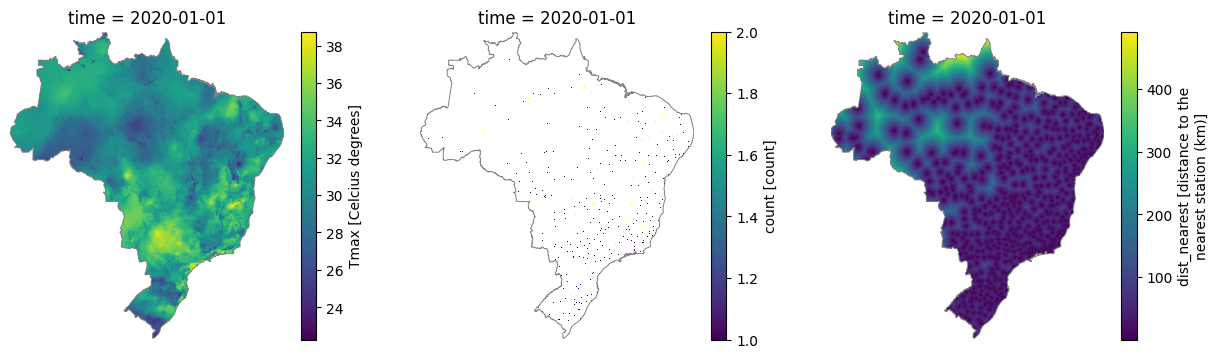

In [19]:
# plotando
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# plotando varíavel no dia
var.sel(time=day2get).plot(ax=ax1), ax1.axis('off')
limite2plot_plt(ax1)

# plotando número de estações dentro da célula no dia
mask = var_count.sel(time=day2get) != 0
var_count.sel(time=day2get).where(mask).plot(ax=ax2), ax2.axis('off')
limite2plot_plt(ax2)

# plotando distância da célula à estação mais próxima
var_dist_nearest.sel(time=day2get).plot(ax=ax3), ax3.axis('off')
limite2plot_plt(ax3)

# para gravar
plt.savefig("para_teste_UFSM.jpeg")

**Plotando em HVPLOT**

In [20]:
var.sel(time=day2get).hvplot.image(coastline=True,  cmap="viridis", tiles=True) + \
var_count.sel(time=day2get).where(var_count.sel(time=day2get) != 0).hvplot.image(coastline=True,  cmap="viridis", tiles=True) + \
var_dist_nearest.sel(time=day2get).hvplot.image(coastline=True,  cmap="viridis", tiles=True) 

/home/alexandre/miniconda3/envs/br-dwgd/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(


:Layout
   .Overlay.I   :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [longitude,latitude]   (Tmax)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II  :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [longitude,latitude]   (count)
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III :Overlay
      .Tiles.I     :Tiles   [x,y]
      .Image.I     :Image   [longitude,latitude]   (dist_nearest)
      .Coastline.I :Feature   [Longitude,Latitude]

## Extraindo dados para uma posição

* Extraindo para uma posição a série histórica diária da temperatura máxima (Tmax)
* calculando a sua media mensal e;
* exportando dados diarios em arquivo cvs:

Definindo variável e período

In [21]:
# Defina variável
name_var = 'Tmax'

# lendo variável
data = xr.open_mfdataset(path_var + name_var + '*.nc')

start_date, end_date = '2010-01-01','2020-12-31'
Tmax_data = data.sel(time=slice(start_date, end_date))

Plotando um dia

In [22]:
Tmax_data.sel(time="2010-01-01")

<xarray.Dataset>
Dimensions:    (latitude: 393, longitude: 391)
Coordinates:
    time       datetime64[ns] 2010-01-01
  * latitude   (latitude) float32 -33.85 -33.75 -33.65 -33.55 ... 5.15 5.25 5.35
  * longitude  (longitude) float32 -73.85 -73.75 -73.65 ... -35.05 -34.95 -34.85
Data variables:
    Tmax       (latitude, longitude) float32 dask.array<chunksize=(393, 391), meta=np.ndarray>
Attributes:
    title:                Brazilian Daily Weather Gridded Data (1961-2020)
    institution:          Federal University of Espirito Santo; University of...
    institution_id:       UFES; UTEXAS
    history:              Created Mon Jun 12 15:54:50 2023
    temporal_resolution:  24-hourly
    contact:              alexandre.xavier@ufes.br; careyking@energy.utexas.e...
    main_code:            gerando_ncfiles_Tmax_Tmin_8bits.py
    update_information:   https://sites.google.com/site/alexandrecandidoxavie...
    main_paper:           Xavier, A.C., Scanlon, B.R., King, C.W. and Alves, ...
    Interpolate_method:   IDW, power: 2; n_neighbor: 5; variation_with_height...

In [23]:
# Com a biblioteca hvplot
Tmax_data.sel(time="2010-01-01").hvplot.image(cmap="viridis", coastline=True, 
                  tiles=True, alpha=0.8, clabel=data[name_var].units) # tiles='ESRI'

:Overlay
   .Tiles.I     :Tiles   [x,y]
   .Image.I     :Image   [longitude,latitude]   (Tmax)
   .Coastline.I :Feature   [Longitude,Latitude]

Plotando dados diários e mensais para o posição
Pegando os dados para a posição de Umuarama/Paraná (lat-23.76,lon=-53.30)

In [24]:
lat, lon = -8.9, -53.02
Tmax_data_temporal = Tmax_data.sel(latitude=lat,longitude=lon, method='nearest')

Tmax_data_temporal

<xarray.Dataset>
Dimensions:    (time: 3865)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-07-31
    latitude   float32 -8.85
    longitude  float32 -53.05
Data variables:
    Tmax       (time) float32 dask.array<chunksize=(3865,), meta=np.ndarray>
Attributes:
    title:                Brazilian Daily Weather Gridded Data (1961-2020)
    institution:          Federal University of Espirito Santo; University of...
    institution_id:       UFES; UTEXAS
    history:              Created Mon Jun 12 15:54:50 2023
    temporal_resolution:  24-hourly
    contact:              alexandre.xavier@ufes.br; careyking@energy.utexas.e...
    main_code:            gerando_ncfiles_Tmax_Tmin_8bits.py
    update_information:   https://sites.google.com/site/alexandrecandidoxavie...
    main_paper:           Xavier, A.C., Scanlon, B.R., King, C.W. and Alves, ...
    Interpolate_method:   IDW, power: 2; n_neighbor: 5; variation_with_height...

**Plotando com Matplotlib**

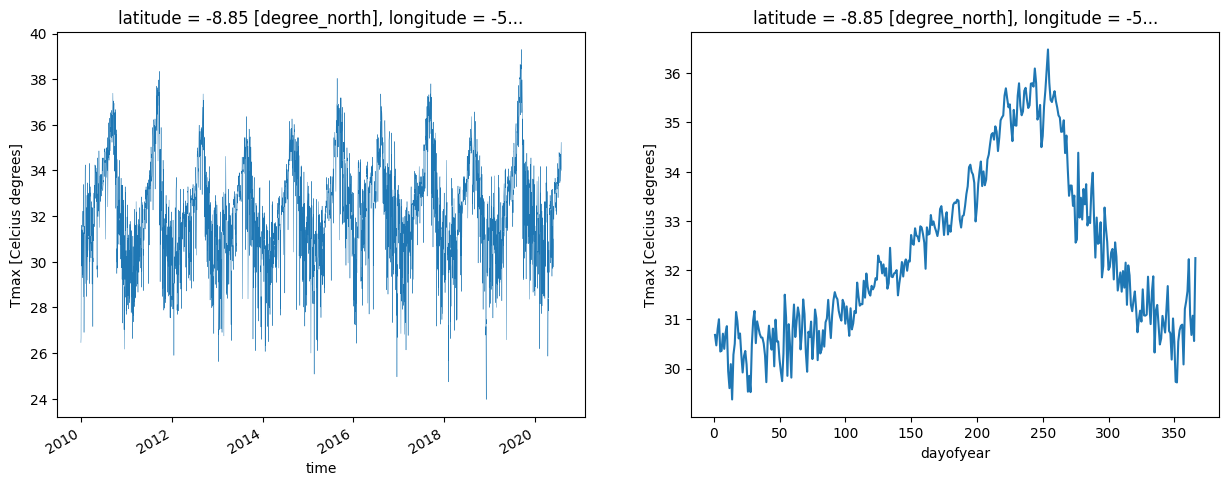

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# plotando a diaria
Tmax_data_temporal[name_var].plot(ax=ax1, linewidth=.3)

# plotando a media mensal
Tmax_mean_groupby = Tmax_data_temporal[name_var].groupby('time.dayofyear').mean('time')
Tmax_mean_groupby.plot(ax=ax2)

**Plotando com hvplot**

In [26]:
Tmax_data_temporal.hvplot(width=500) + Tmax_mean_groupby.hvplot(width=400)

/home/alexandre/miniconda3/envs/br-dwgd/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/home/alexandre/miniconda3/envs/br-dwgd/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .Curve.I  :Curve   [time]   (Tmax)
   .Curve.II :Curve   [dayofyear]   (Tmax)

In [27]:
Tmax_mean_groupby.hvplot()

:Curve   [dayofyear]   (Tmax)

Exportando dados diarios em cvs: nome do arquivo 'Tmax.cvs'

In [28]:
fileName = 'Tmax.csv'
days = np.array(Tmax_data_temporal.time)
data_dataframe = pd.DataFrame(np.array(Tmax_data_temporal[name_var]), index=days)
data_dataframe.to_csv(fileName, float_format='%.1f')

In [29]:
data_dataframe

0
2010-01-01  26.459091
2010-01-02  26.664173
2010-01-03  29.842983
2010-01-04  31.517838
2010-01-05  31.603291
...               ...
2020-07-27  33.936127
2020-07-28  34.346294
2020-07-29  34.790642
2020-07-30  35.234993
2020-07-31  34.004486

[3865 rows x 1 columns]

## Plotando média mensal da Umidade Relativa, todo Brasil

Pegando RH para o periodo e calculando a media mensal

In [30]:
ds = xr.open_mfdataset(path_var + 'RH*.nc')

# definindo período a ser avaliado
start_date, end_date = '1990-01-01', '1999-12-31'
RH_data = ds.RH.sel(time=slice(start_date, end_date))

# agrupando em media mensal
RH_mean_month = RH_data.groupby('time.month').mean('time')
RH_mean_month

<xarray.DataArray 'RH' (month: 12, latitude: 393, longitude: 391)>
dask.array<stack, shape=(12, 393, 391), dtype=float32, chunksize=(1, 393, 391), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -33.85 -33.75 -33.65 -33.55 ... 5.15 5.25 5.35
  * longitude  (longitude) float32 -73.85 -73.75 -73.65 ... -35.05 -34.95 -34.85
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    valid_min:      0
    valid_max:      254
    FillValue:      255
    units:          %
    standard_name:  RH
    _ChunkSizes:    [7305  393  391]

Plotando

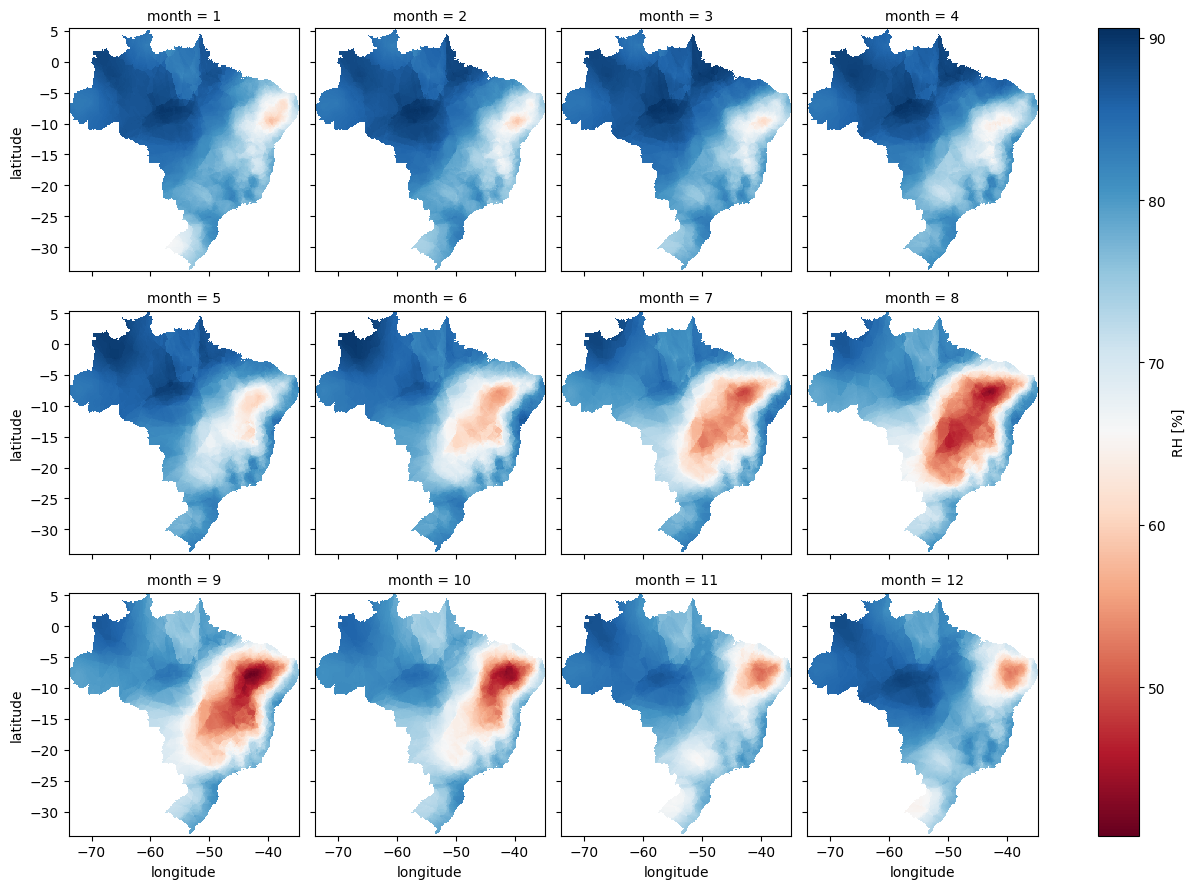

In [31]:
RH_mean_month.plot(x='longitude', y='latitude', col='month',
                   cmap='RdBu', col_wrap=4)

## Plotando a média mensal da ET0 para algumas cidades

Pegando variável

In [32]:
var = xr.open_mfdataset(path_var + 'Tmax*.nc')["Tmax"]

start_date, end_date = '1990-01-01', '2009-12-31'
var = var.sel(time=slice(start_date, end_date))


Cidades e coordenadas

In [33]:
cityInformation = {
    'Santa Maria-RS': [-29.7, -53.7],
    'Manaus-AM': [-3., -60.],
    'Petrolina-PE': [-9.4, -40.5],
    'Alegre-ES': [-20.7, -41.5]
}
pd.DataFrame(cityInformation, index=['lat', 'lon'])

Santa Maria-RS  Manaus-AM  Petrolina-PE  Alegre-ES
lat           -29.7       -3.0          -9.4      -20.7
lon           -53.7      -60.0         -40.5      -41.5

Calculando a média mensal

In [34]:
varMean = var.resample(time='M').mean('time')
varMean

<xarray.DataArray 'Tmax' (time: 240, latitude: 393, longitude: 391)>
dask.array<stack, shape=(240, 393, 391), dtype=float32, chunksize=(1, 393, 391), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -33.85 -33.75 -33.65 -33.55 ... 5.15 5.25 5.35
  * longitude  (longitude) float32 -73.85 -73.75 -73.65 ... -35.05 -34.95 -34.85
  * time       (time) datetime64[ns] 1990-01-31 1990-02-28 ... 2009-12-31
Attributes:
    valid_min:      -32767
    valid_max:      32767
    FillValue:      -32768
    units:          Celcius degrees
    standard_name:  Tmax
    _ChunkSizes:    [7305  393  391]

Santa Maria-RS -29.7 -53.7
Manaus-AM -3.0 -60.0
Petrolina-PE -9.4 -40.5
Alegre-ES -20.7 -41.5


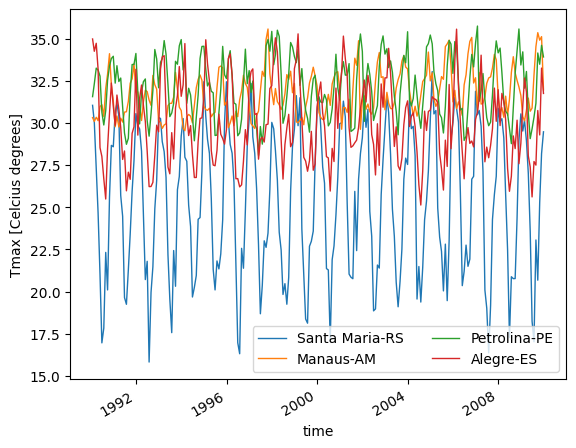

In [35]:
_, ax = plt.subplots(1,1)
for city, cityCoord in cityInformation.items():
    print(city, cityCoord[0], cityCoord[1])
    varMean.sel(latitude=cityCoord[0], longitude=cityCoord[1],
                method='nearest').plot(ax=ax, label=city, linewidth=1)

# plt.ylim(1, 8)
plt.title('')
plt.legend(ncol=2)

**Plotando as probabilidades de Tmax para algumas latitudes [ver aqui](https://hvplot.holoviz.org/reference/pandas/kde.html)**

In [36]:
varMean.sel(latitude=[-33, -20, 0], method="nearest").hvplot.kde('Tmax', by='latitude', alpha=0.5)

:NdOverlay   [latitude]
   :Distribution   [Tmax]   (Density)

Plotando

## Plotar média temporal com intervalo de confiança

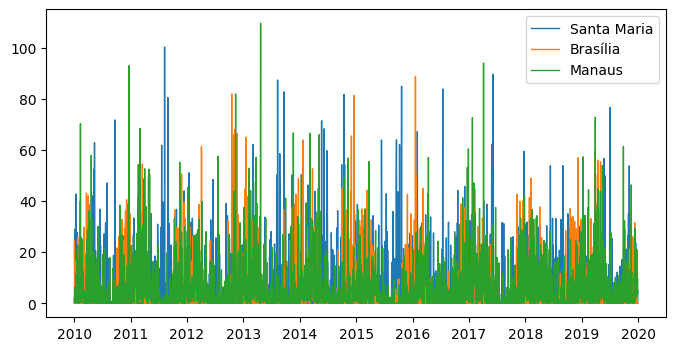

In [37]:
# definição da variável, cidades, localizações e período
var2get = "pr" #"RH"

cidades = [["Santa Maria", "Brasília", "Manaus"]]
lat, lon = [-28.3, -15.78, -3.1], [-49.94, -47.92, -60]

# Período para gerar as médias
day_first, day_last = '2010-01-01', '2019-12-31' 

# pegando os dados para o período
var = xr.open_mfdataset(path_var + var2get + '*.nc')[var2get]
var = var.sel(time=slice(day_first, day_last))

# pegando os dados da posições lat e lon
var_pos = var.sel(longitude=xr.DataArray(lon, dims='z'),
                    latitude=xr.DataArray(lat, dims='z'),  method='nearest')

# plotando diária
plt.figure(figsize=(8,4))
for n in range(len(lat)):
    plt.plot(var_pos.time, var_pos.isel(z=n), label=cidades[0][n], linewidth=1)
               
plt.legend()

Cidade  DOY  Mês   Ano         pr
0      Santa Maria    1    1  2010   0.151062
1      Santa Maria    2    1  2010   0.061798
2      Santa Maria    3    1  2010   0.000000
3      Santa Maria    4    1  2010   4.916534
4      Santa Maria    5    1  2010  29.004791
...            ...  ...  ...   ...        ...
10951       Manaus  361   12  2019   6.056396
10952       Manaus  362   12  2019   3.385269
10953       Manaus  363   12  2019   6.076996
10954       Manaus  364   12  2019   8.912933
10955       Manaus  365   12  2019   9.475998

[10956 rows x 5 columns]

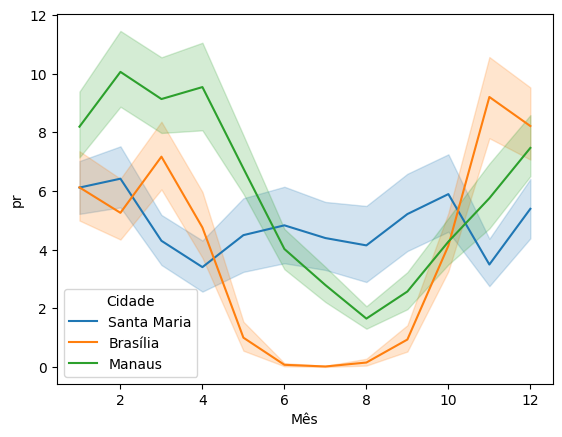

In [38]:
# organizando os dados para o DataFrame
doy = np.tile(var_pos.time.dt.dayofyear, len(lat))
mes = np.tile(var_pos.time.dt.month, len(lat))
ano = np.tile(var_pos.time.dt.year, len(lat))
var2df = var_pos.values.T.flatten()
cidades2df = np.tile(cidades, 
                     (len(var_pos.time.dt.dayofyear), 1)).T.flatten()

# gerando o DataFrame
df = pd.DataFrame(cidades2df, columns=["Cidade"])
df["DOY"] = doy
df["Mês"] = mes
df["Ano"] = ano
df[var2get] = var2df

# sns.lineplot(x="Mês", y=var2get, hue="Cidade", data=df)
sns.lineplot(x="Mês", y=var2get, hue="Cidade", data=df)

df

## Temperatura média intervalo de confiança

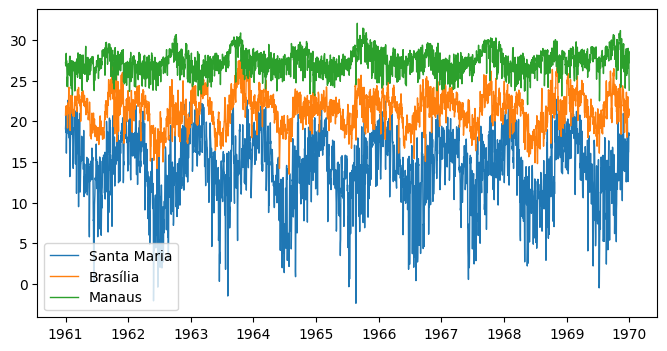

In [39]:
cidades = [["Santa Maria", "Brasília", "Manaus"]]
lat, lon = [-28.3, -15.78, -3.1], [-49.94, -47.92, -60]

# Período para gerar as médias
day_first, day_last = '1961-01-01', '1969-12-31' 

# pegando os dados para o período
tmax = xr.open_mfdataset(path_var + 'Tmax*.nc')["Tmax"].sel(time=slice(day_first, day_last))
tmin = xr.open_mfdataset(path_var + 'Tmin*.nc')["Tmin"].sel(time=slice(day_first, day_last))

tmean = (tmax + tmin)/2
# pegando os dados da posições lat e lon
var_pos = tmean.sel(longitude=xr.DataArray(lon, dims='z'),
                    latitude=xr.DataArray(lat, dims='z'),  method='nearest')

# plotando diária
plt.figure(figsize=(8,4))
for n in range(len(lat)):
    plt.plot(var_pos.time, var_pos.isel(z=n), label=cidades[0][n], linewidth=1)
               
plt.legend()

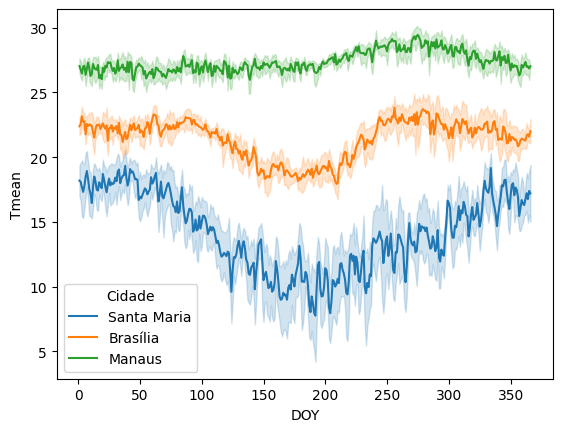

In [42]:
# organizando os dados para o DataFrame
doy = np.tile(var_pos.time.dt.dayofyear, len(lat))
mes = np.tile(var_pos.time.dt.month, len(lat))
ano = np.tile(var_pos.time.dt.year, len(lat))
var2df = var_pos.values.T.flatten()
cidades2df = np.tile(cidades, (len(var_pos.time.dt.dayofyear), 1)).T.flatten()

# gerando o DataFrame
df = pd.DataFrame(cidades2df, columns=["Cidade"])
df["DOY"] = doy
df["Mês"] = mes
df["Ano"] = ano
df["Tmean"] = var2df

# sns.lineplot(x="Mês", y=var2get, hue="Cidade", data=df)
fig_media = sns.lineplot(x="DOY", y="Tmean", hue="Cidade", data=df)

In [43]:
fig = fig_media.get_figure()
fig.savefig("plot2.jpeg", dpi=400) 

## Plotando dados de controle no tempo

Para todas as variaveis existem dois controles

(*i*) a distancia do centro da celula a estacao mais proxima (**dist_nearest**) e;

(*ii*) o numero de estacoes/pluviometros dentro da celula (**count**). 

Serão plotados os controles da grade precipitacão em duas localidades, Sorriso-MT e Campinas-SP (na verdade é da celula mais proxima a estas cidades).

Lendo dados

In [44]:
ds = xr.open_mfdataset(path_control + 'pr_Control*.nc')
dist_nearest = ds['dist_nearest']
count = ds['count']
ds

<xarray.Dataset>
Dimensions:       (time: 22645, latitude: 393, longitude: 391)
Coordinates:
  * time          (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2022-12-31
  * latitude      (latitude) float32 -33.85 -33.75 -33.65 ... 5.15 5.25 5.35
  * longitude     (longitude) float32 -73.85 -73.75 -73.65 ... -34.95 -34.85
Data variables:
    dist_nearest  (time, latitude, longitude) float32 dask.array<chunksize=(7305, 393, 391), meta=np.ndarray>
    count         (time, latitude, longitude) float32 dask.array<chunksize=(7305, 393, 391), meta=np.ndarray>
Attributes:
    title:                Brazilian Daily Weather Gridded Data (1961-2020)
    institution:          Federal University of Espirito Santo; University of...
    institution_id:       UFES; UTEXAS
    history:              Created Mon Jun 12 15:02:05 2023
    temporal_resolution:  24-hourly
    contact:              alexandre.xavier@ufes.br; careyking@energy.utexas.e...
    main_code:            gerando_ncfiles_pr_8bits.py
    update_information:   https://sites.google.com/site/alexandrecandidoxavie...
    main_paper:           Xavier, A.C., Scanlon, B.R., King, C.W. and Alves, ...

Definindo posições

In [45]:
posicoes = {'Sorriso-MT': [-12.5, -55.7],
            'Santa Maria-RS': [-29.7, -53.8]}

Plotando distancia do pluviometro mais proximo, ao longo do tempo, que foi utilizado na interpolacao

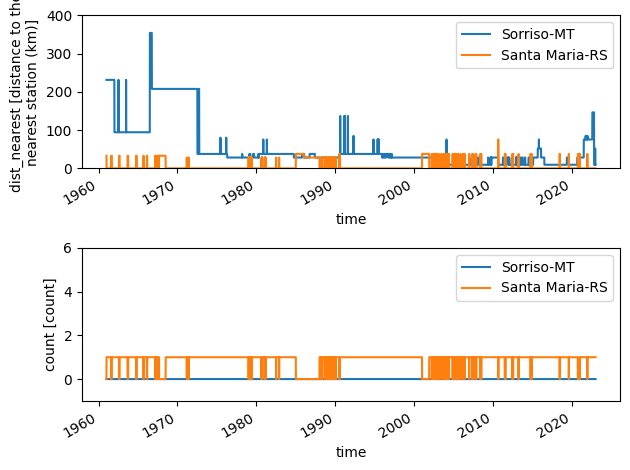

In [46]:
_, (ax1, ax2) = plt.subplots(2, 1)
for names, lat_lon in posicoes.items():
    dist_nearest.sel(latitude=lat_lon[0],
                     longitude=lat_lon[1],
                     method='nearest').plot(ax=ax1, label=names)

    # número de estações que contem na célula
    count.sel(latitude=lat_lon[0],
              longitude=lat_lon[1],
              method='nearest').plot(ax=ax2, label=names)

ax1.set_ylim(0, 400)
ax1.legend()
ax1.set_title('')
ax2.set_ylim(-1, 6)
ax2.legend()
ax2.set_title('')
plt.tight_layout()

## Diferença entre precipitação e ETo  

Calculo da diferenca sazonal entre a precipitacao e a ET0 para o Brasil utilizando os dados gradeados 
(periodo de 1980/01/01  a 2009/12/31)

Pegando variáveis

In [47]:
ETo = xr.open_mfdataset(path_var + 'ETo*.nc')
prec = xr.open_mfdataset(path_var + 'pr*.nc')

criando mascara para o continente e mar

<xarray.DataArray 'season' (time: 21762)>
array(['DJF', 'DJF', 'DJF', ..., 'JJA', 'JJA', 'JJA'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2020-07-31

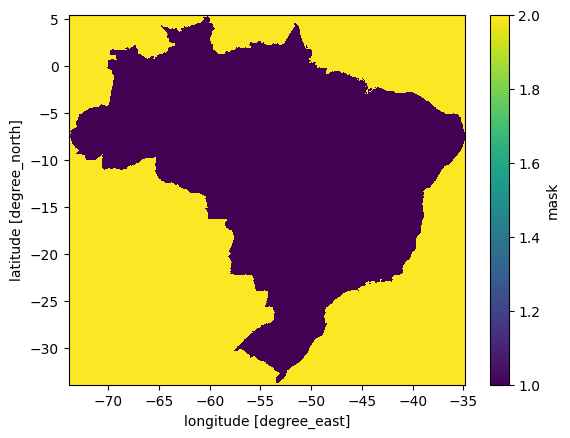

In [48]:
mask_ocean = 2 * np.ones(prec['pr'].shape[1:]) * np.isnan(prec['pr'].isel(time=0))
mask_land = 1 * np.ones(prec['pr'].shape[1:]) * ~np.isnan(prec['pr'].isel(time=0))
mask_array = mask_ocean + mask_land

# incorporando mascara em ETo
# ETo.coords['mask'] = (('latitude', 'longitude'), mask_array.values)
ETo.coords['mask'] = xr.DataArray(mask_array.values, dims=('latitude', 'longitude'))
ETo.mask.plot()
ETo.time.dt.season


Intervalo da seria histórica para os cálculos e reamostrando para a media mensal diaria

In [49]:
date_start, date_end = '2010-01-01', '2011-12-31' # '1980-01-01', '2009-12-31'

EToSlice = ETo['ETo'].loc[dict(time=slice(date_start, date_end))].resample(time='M').mean('time')
precSlice = prec['pr'].loc[dict(time=slice(date_start, date_end))].resample(time='M').mean('time')

# agrupando nas estacoes ('DJF', 'MAM', 'JJA', 'SON')
EToSeason = EToSlice.groupby('time.season').mean(dim='time')
precSeason = precSlice.groupby('time.season').mean(dim='time')

# calculando diferencas sazonais entre prec e ETo
diff = precSeason - EToSeason
diff

<xarray.DataArray (season: 4, latitude: 393, longitude: 391)>
dask.array<sub, shape=(4, 393, 391), dtype=float32, chunksize=(1, 393, 391), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -33.85 -33.75 -33.65 -33.55 ... 5.15 5.25 5.35
  * longitude  (longitude) float32 -73.85 -73.75 -73.65 ... -35.05 -34.95 -34.85
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
    mask       (latitude, longitude) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0

Plotando

Text(0.5, 0.98, 'Diferença sazonal entre precipitação e ETo')

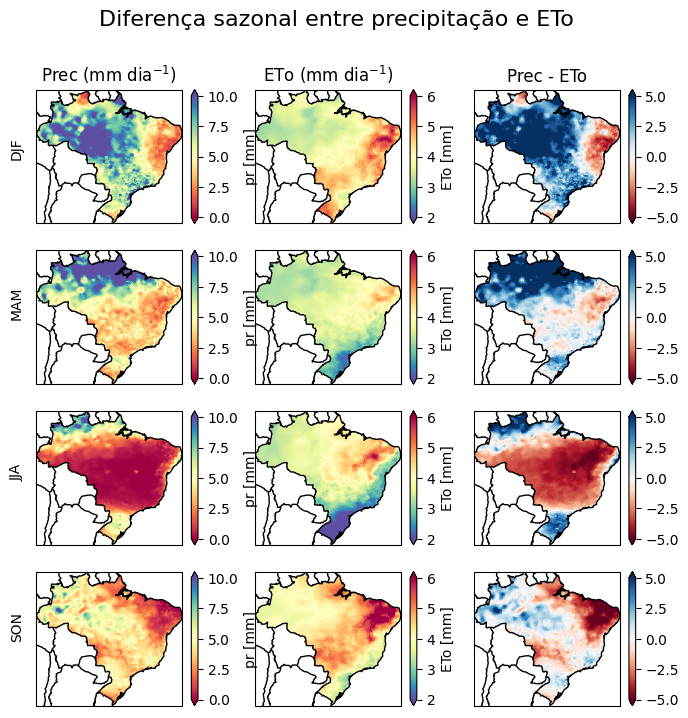

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=3,
                         figsize=(8, 8),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    precSeason.where(ETo.mask == 1).sel(season=season).plot(
        ax=axes[i, 0], transform=ccrs.PlateCarree(), cmap='Spectral',
        vmin=0, vmax=10, extend='both',)

    EToSeason.where(ETo.mask == 1).sel(season=season).plot(
        ax=axes[i, 1],  transform=ccrs.PlateCarree(), cmap='Spectral_r',
        vmin=2, vmax=6, extend='both',)

    diff.where(ETo.mask == 1).sel(season=season).plot(
        ax=axes[i, 2],  transform=ccrs.PlateCarree(), cmap='RdBu',
        vmin=-5, vmax=5, extend='both',)

    axes[i, 0].text(-78, -15, season,
                    rotation='vertical',
                    rotation_mode='anchor',)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for n, ax in enumerate(axes.flat):
    # pdb.set_trace()
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_title('')
    ax.coastlines()
    ax.add_feature(BORDERS)

axes[0, 0].set_title('Prec (mm dia$^{-1}$)')
axes[0, 1].set_title('ETo (mm dia$^{-1}$)')
axes[0, 2].set_title('Prec - ETo')

fig.suptitle('Diferença sazonal entre precipitação e ETo',
            fontsize=16, y=.98)

## Normal da temperatura media ([Tmax + Tmin]/2) do mês janeiro

Pegando Tmax e Tmin, calculando media mensais para o periodo

In [56]:
# definição das datas para calculo das normais
day_first, day_last = '1961-01-01', '1990-12-31' # '1961-01-01', '1990-12-31'

tmax = xr.open_mfdataset(path_var + 'Tmax*.nc').Tmax
tmax_month = tmax.sel(time=slice(day_first, day_last)).groupby('time.month').mean('time')

tmin = xr.open_mfdataset(path_var + 'Tmin*.nc').Tmin
tmin_month = tmin.sel(time=slice(day_first, day_last)).groupby('time.month').mean('time')

t_mean_month = ((tmax_month + tmin_month) / 2).compute()

Plotando normal, mes de Janeiro

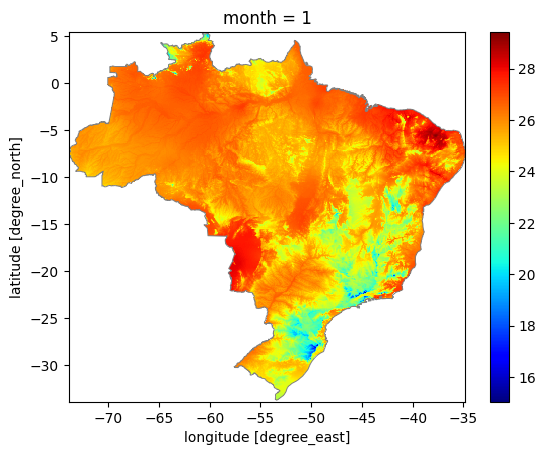

In [57]:
month = 1 # 1=janeiro, 2=fevereiro, .... 12=dezembro
_, ax = plt.subplots(1,1)
t_mean_month.sel(month=month).plot(ax=ax,cmap=plt.cm.jet)
limite2plot_plt(ax)

Plotando as medias para todos os meses

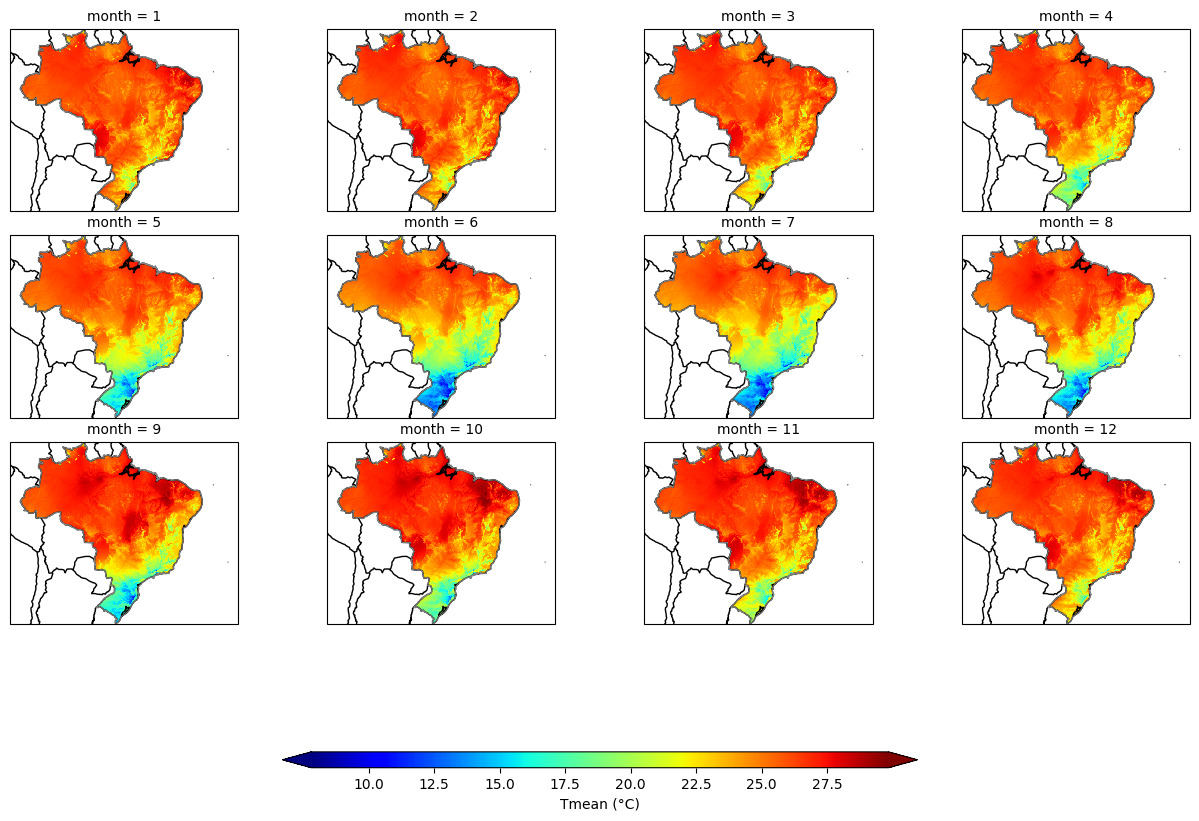

In [58]:
p = t_mean_month.plot(transform=ccrs.PlateCarree(), cmap=plt.cm.jet, 
                      col='month', col_wrap=4,
                      subplot_kws={'projection': ccrs.PlateCarree()}, extend='both',
                      cbar_kwargs={"orientation": "horizontal","shrink": .5, 
                                   "aspect": 40, "label": "Tmean (°C)"
                         })

for ax in p.axs.flat:
    ax.coastlines()
    ax.add_feature(BORDERS)
    limite2plot_plt(ax)

## Comportamento da temperatuta média anual em diferentes regioes do Brasil
O script abaixo, não sei se roda em computador com pouca memória RAM

In [59]:
import dask.array as da
tmax = xr.open_mfdataset(path_var + 'Tmax*.nc').Tmax


tmax

<xarray.DataArray 'Tmax' (time: 21762, latitude: 393, longitude: 391)>
dask.array<concatenate, shape=(21762, 393, 391), dtype=float32, chunksize=(7305, 393, 391), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1961-01-01 1961-01-02 ... 2020-07-31
  * latitude   (latitude) float32 -33.85 -33.75 -33.65 -33.55 ... 5.15 5.25 5.35
  * longitude  (longitude) float32 -73.85 -73.75 -73.65 ... -35.05 -34.95 -34.85
Attributes:
    valid_min:      -32767
    valid_max:      32767
    FillValue:      -32768
    units:          Celcius degrees
    standard_name:  Tmax
    _ChunkSizes:    [7305  393  391]

In [60]:
# definição da dadas para calculos
day_first, day_last = '1961-01-01', '2019-12-31' #'1961-01-01', '2019-12-31'

# pegando Tmax e Tmin, v2.1 e calculando as suas respectivas medias anuais
tmax = xr.open_mfdataset(path_var + 'Tmax*.nc').Tmax
tmax_yearly = tmax.sel(time=slice(day_first, day_last)).resample(time='Y').mean('time').compute()

tmin = xr.open_mfdataset(path_var + 'Tmin*.nc').Tmin
tmin_yearly = tmin.sel(time=slice(day_first, day_last)).resample(time='Y').mean('time').compute()

# Temperatura anual
temp_mean_yearly = ((tmax_yearly+tmin_yearly) / 2).compute()

Cálculos dos pesos das celulas de acordo com sua latitude

In [61]:
weights = np.cos(np.deg2rad(temp_mean_yearly.latitude))
weights.name = "weights"

In [62]:
# definindo regioes: cada linha tem as coordenadas limites da respectiva região na ordem:
# sul, sudeste, nordeste, centro-oeste, norte
names_regions = ['Sul', 'Sudeste', 'Nordeste', 'Centro-Oeste', 'Norte']
names_regions_abre = ['S', 'SE', 'NE', 'CO', 'N',]
regiao_lat = [[-34, -22],
              [-25.6, -13.8],
              [-18.6, -1],
              [-24.3, -7],
              [-12.7, 6]]

regiao_lon = [[-58, -47.2],
              [-51.5, -39],
              [-49, -34.4],
              [-62, -45.6],
              [-74, -46.3]]

## Extraindo dados anuais e plotando os limites das regiões

Sul
Sudeste
Nordeste
Centro-Oeste
Norte


year     t_mean region
0   1961.0  20.389755    Sul
1   1962.0  18.991114    Sul
2   1963.0  20.178461    Sul
3   1964.0  19.168274    Sul
4   1965.0  19.578827    Sul
..     ...        ...    ...
54  2015.0  27.566387  Norte
55  2016.0  27.561964  Norte
56  2017.0  27.236391  Norte
57  2018.0  26.996132  Norte
58  2019.0  27.291315  Norte

[295 rows x 3 columns]

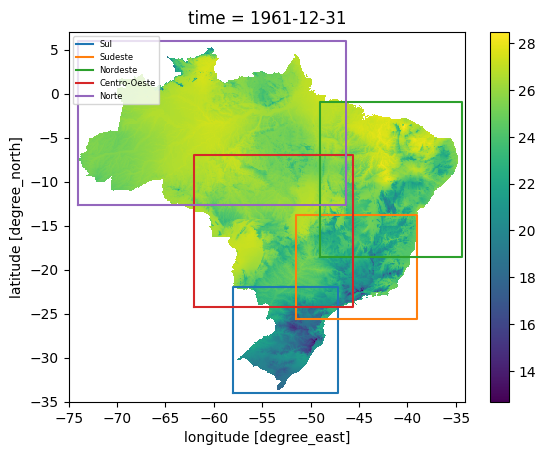

In [63]:
# figura regioes
fig, ax = plt.subplots(1)
temp_mean_yearly.isel(time=0).plot(ax=ax)

# calculation of the regions yearly Tmean
for n in range(len(names_regions)):
    print(names_regions[n])
    lat_min, lat_max = regiao_lat[n][0], regiao_lat[n][1]
    lon_min, lon_max = regiao_lon[n][0], regiao_lon[n][1]

    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
            [lat_min, lat_min, lat_max, lat_max, lat_min], label=names_regions[n])

    # creating a mask of the region
    mask = (lon_min < tmax_yearly.longitude) & (lon_max > tmax_yearly.longitude) & \
           (lat_min < tmax_yearly.latitude) &  (lat_max > tmax_yearly.latitude)
    # yearly tmean to Dataframe
    # inserindo o peso na regiao
    temp_mean_yearly_r = temp_mean_yearly.where(mask)
    temp_mean_yearly_w = temp_mean_yearly_r.weighted(weights)
    temp_mean_yearly_region_w = temp_mean_yearly_w.mean(['latitude', 'longitude']).values
    df_region = pd.DataFrame(np.c_[temp_mean_yearly_r.time.dt.year,
                                   temp_mean_yearly_region_w], columns=['year', 't_mean'])
    df_region['region'] = names_regions[n]
    if n == 0:
        df_all = df_region
    else:
        df_all = pd.concat([df_all, df_region])

ax.legend(loc=2, prop={'size': 6})
ax.set_xlim(-75, -34)
ax.set_ylim(-35, 7)
df_all

## Gráfico *simple linear regression* "year" versus "t_mean" para cada regiao

/home/alexandre/miniconda3/envs/br-dwgd/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_17185/2319396601.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


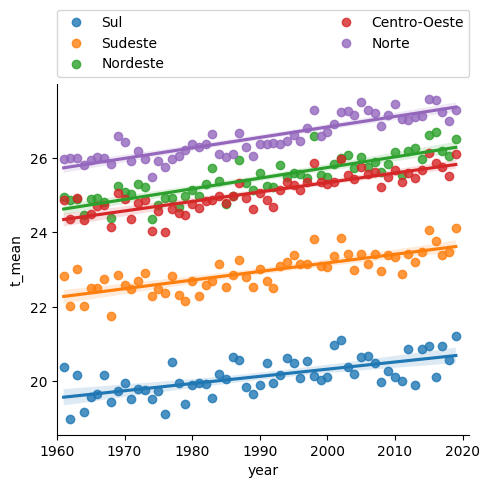

In [64]:
g = sns.lmplot(x='year', y="t_mean", hue="region", data=df_all, legend=False)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(1960,2021)
plt.tight_layout()

# estatisticas por regiao na variavel "stat_region"
df_all['year_ano'] = df_all['year']
df_all['datas'] = df_all.index.values
df_all['name_legend'] = ''
stat_region = np.zeros((5,4))
for n in np.arange(5):
    x = df_all[df_all['region'] == names_regions[n]].year_ano.values
    y = df_all[df_all['region'] == names_regions[n]].t_mean.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    stat_region[n] = np.array([slope, r_value, p_value, std_err])



In [65]:
pd.DataFrame(stat_region, index=names_regions_abre,
            columns=["slope", "r_value", "p_value", "std_err"])

slope   r_value       p_value   std_err
S   0.019294  0.656372  1.660486e-08  0.002937
SE  0.023132  0.778985  3.731128e-13  0.002466
NE  0.028579  0.854809  7.069667e-18  0.002298
CO  0.025469  0.843314  5.261650e-17  0.002150
N   0.028135  0.877586  7.541230e-20  0.002036